Outputs which include images had been removed since github page returns an error when showing a large size file.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)



In [3]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
plt.figure(figsize=(10, 5)) # these images had been shuffeld by the publisher?


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}', color='blue')
    plt.axis('off')

In [6]:
print(metadata.features['label'].names) # it has 5 classes. 0: Dandelion, 1: Daisy, 2: Tulips, 3: Sunflowers, 4: Roses

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [7]:
import tensorflow as tf
IMG_SIZE = 160 # All images will be resized to 160x160. If I scale the images up, will the accuracy increase?

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # type casting
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # How does this 'resizing' work?
    return image, label

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
plt.figure(figsize=(10, 5)) 


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}', color='blue')
    plt.axis('off')

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [11]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [14]:
BATCH_SIZE = 32 # determining batch size which will be trained for one step.
SHUFFLE_BUFFER_SIZE = 1000 # shuffles the training data.

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    image_batch = (image_batch + 1) / 2
    plt.imshow(image_batch[0])
    pass

image_batch.shape, label_batch.shape


In [16]:
validation_steps = 12
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 3s 245ms/step - loss: 1.5986 - accuracy: 0.2616
initial loss: 1.60
initial accuracy: 0.26


In [17]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 12s 125ms/step - loss: 1.4562 - accuracy: 0.3965 - val_loss: 1.4205 - val_accuracy: 0.3733
Epoch 2/10
92/92 [==============================] - 3s 30ms/step - loss: 1.1142 - accuracy: 0.5439 - val_loss: 1.0591 - val_accuracy: 0.5777
Epoch 3/10
92/92 [==============================] - 3s 29ms/step - loss: 0.9746 - accuracy: 0.6216 - val_loss: 1.0120 - val_accuracy: 0.5858
Epoch 4/10
92/92 [==============================] - 3s 28ms/step - loss: 0.8662 - accuracy: 0.6723 - val_loss: 0.9619 - val_accuracy: 0.6022
Epoch 5/10
92/92 [==============================] - 2s 27ms/step - loss: 0.7442 - accuracy: 0.7374 - val_loss: 0.9543 - val_accuracy: 0.6213
Epoch 6/10
92/92 [==============================] - 3s 31ms/step - loss: 0.6561 - accuracy: 0.7653 - val_loss: 0.9778 - val_accuracy: 0.6213
Epoch 7/10
92/92 [==============================] - 3s 30ms/step - loss: 0.5652 - accuracy: 0.8062 - val_loss: 0.9243 - val_accuracy: 0.6403
Epoch 8/10


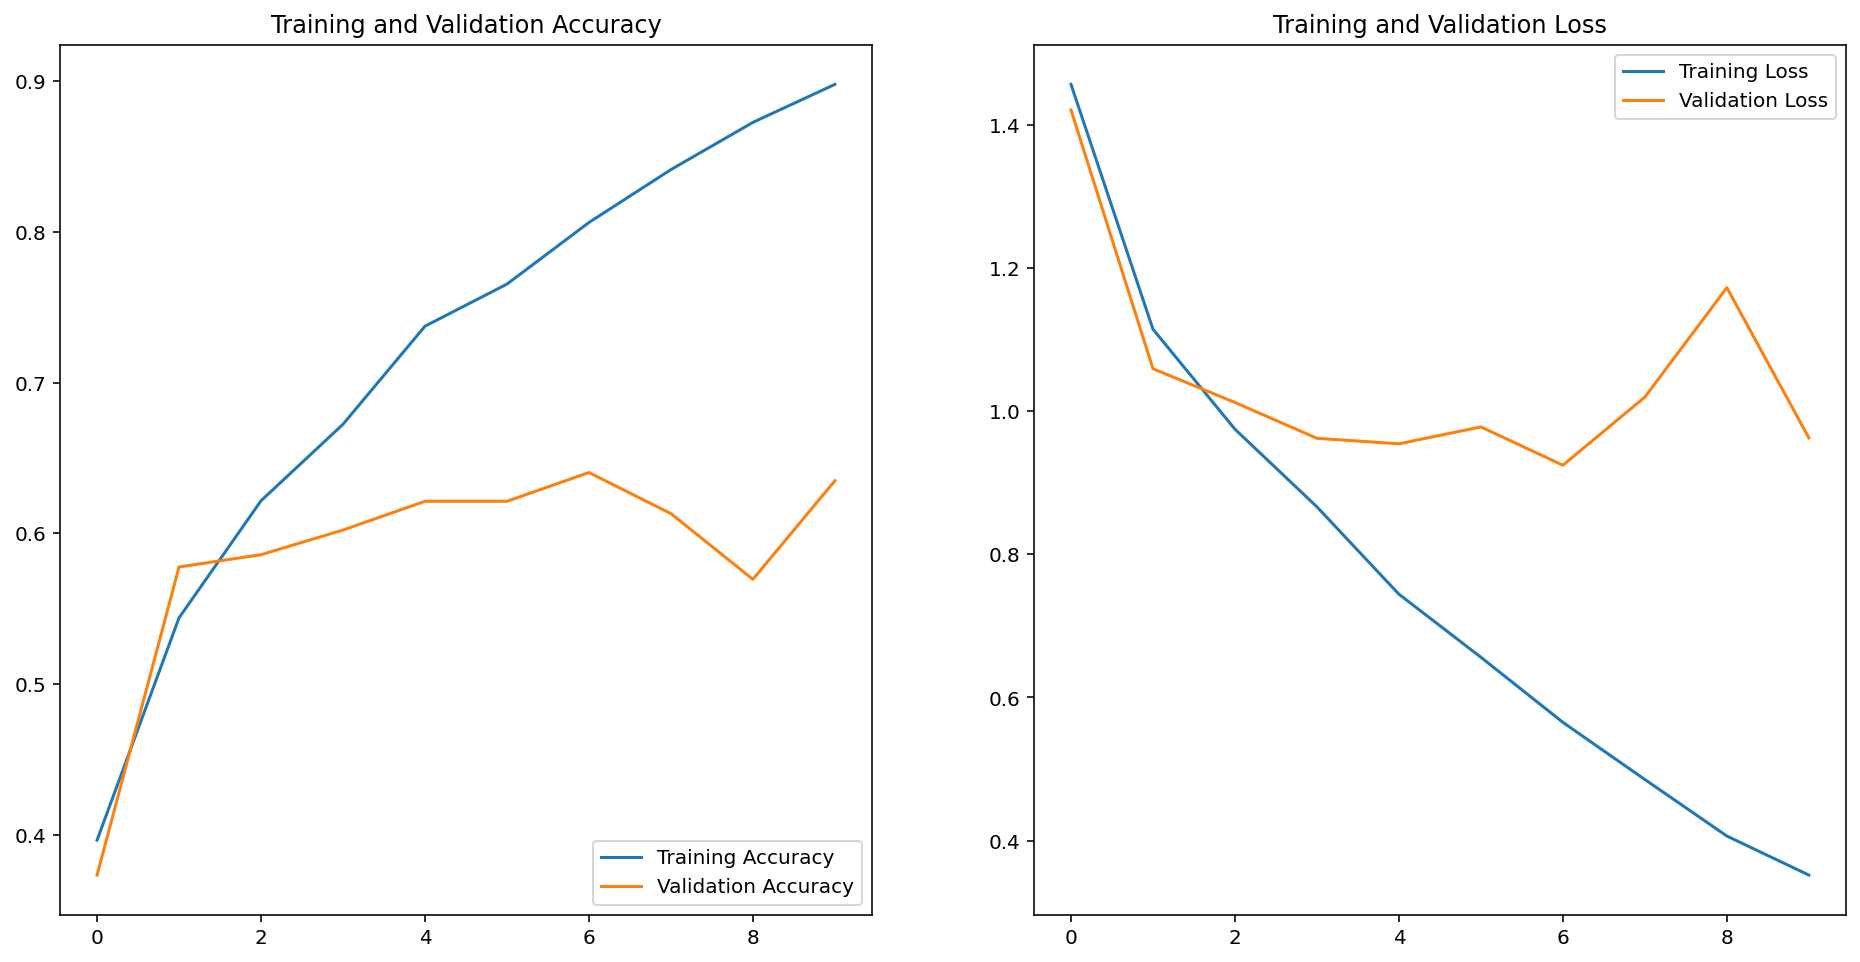

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[1.14604719e-02, 1.26432674e-02, 2.25108892e-01, 4.94318634e-01,
        2.56468743e-01],
       [7.76731253e-01, 2.16133997e-01, 4.71908087e-03, 4.36381000e-04,
        1.97935104e-03],
       [2.84570247e-01, 2.83582956e-02, 1.41351044e-01, 5.38352013e-01,
        7.36836018e-03],
       [2.00115144e-01, 1.73296139e-01, 3.00952256e-01, 7.18635917e-02,
        2.53772885e-01],
       [7.61249065e-01, 2.90920194e-02, 1.66768506e-02, 2.67016385e-02,
        1.66280389e-01],
       [4.31392968e-01, 3.46012473e-01, 3.73611934e-02, 2.18074415e-02,
        1.63425893e-01],
       [7.47541245e-03, 6.81783929e-02, 6.80703819e-01, 2.97467504e-02,
        2.13895589e-01],
       [2.44547620e-01, 9.77299139e-02, 1.60172507e-01, 8.32654908e-02,
        4.14284438e-01],
       [4.75866254e-03, 5.34646933e-05, 3.30024119e-03, 9.91778672e-01,
        1.08843735e-04],
       [9.77161288e-01, 1.64668970e-02, 8.82111141e-04, 6.65198604e-04,
        4.82454896e-03],
       [9.32307065e-01, 4.4513

In [20]:
import numpy as np
predictions = np.argmax(predictions, axis=1) # argmax returns indices of the max values along an axis.
predictions

array([3, 0, 3, 2, 0, 0, 2, 4, 3, 0, 0, 3, 3, 4, 4, 3, 2, 3, 1, 4, 2, 0,
       1, 0, 1, 3, 4, 4, 2, 3, 0, 0])

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'green'})
    plt.axis('off')

In [22]:
count = 0   
for image, label, prediction in zip(images, labels, predictions):
  if label == prediction:
    count += 1
  
print('The model predicts correctly with', count / 32 * 100, 'of probability')    # accuracy percentage

The model predicts correctly with 65.625 of probability


In [23]:
import os
img_dir_path = os.getenv("HOME") + "/workplace/Flower_image_classification"
os.path.exists(img_dir_path)

True

In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
import os
checkpoint_dir = os.getenv("HOME") + "/workplace/Flower_image_classification"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

IMG_SIZE = 160
rose_image_path = os.path.join(img_dir_path, 'rose1.jpeg')

rose_image = load_img(rose_image_path, target_size=(IMG_SIZE, IMG_SIZE))
rose_image

In [26]:
rose_image = img_to_array(rose_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
rose_image.shape

(1, 160, 160, 3)

In [27]:
prediction = model.predict(rose_image)
prediction

array([[0., 0., 0., 0., 1.]], dtype=float32)

In [28]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandelion_percentage = round(prediction[0] * 100)
    daisy_percentage = round(prediction[1] * 100)
    tulip_percentage = round(prediction[2] * 100)
    sunflower_percentage = round(prediction[3] * 100)
    rose_percentage = round(prediction[4] * 100)
    print(f"This image seems \n {dandelion_percentage}% dandelion, {daisy_percentage}% daisy, {tulip_percentage}% tulip, {sunflower_percentage}% sunflower, {rose_percentage}% rose.")

In [ ]:
filename = 'rose1.jpeg'

show_and_predict_image(img_dir_path, filename)

In [ ]:
filename = 'dandelion1.jpg' # Using the function, any image can be predicted

show_and_predict_image(img_dir_path, filename)

In [31]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')
print(image_batch.shape) # batch of images
feature_batch = base_model(image_batch)
print(feature_batch.shape) # output batch

# Create a new classifier with global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # (5, 5, 512) -> (1, 1, 512)
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape) 

dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 160, 160, 3)
(32, 5, 5, 512)
(32, 512)
(32, 5)


In [32]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [33]:
base_model.trainable = False # base model (VGG16) is not set to be trained

VGG16_model = Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])
VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
base_learning_rate = 0.0001
VGG16_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

validation_steps = 12
loss0, accuracy0 = VGG16_model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 17s 1s/step - loss: 1.6800 - accuracy: 0.1499
initial loss: 1.68
initial accuracy: 0.15


In [35]:
EPOCHS = 5 

history = VGG16_model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
92/92 [==============================] - 26s 283ms/step - loss: 1.3726 - accuracy: 0.5249 - val_loss: 1.1599 - val_accuracy: 0.7084
Epoch 2/5
92/92 [==============================] - 7s 81ms/step - loss: 1.0476 - accuracy: 0.7081 - val_loss: 0.9039 - val_accuracy: 0.7384
Epoch 3/5
92/92 [==============================] - 8s 87ms/step - loss: 0.8637 - accuracy: 0.7439 - val_loss: 0.7714 - val_accuracy: 0.7439
Epoch 4/5
92/92 [==============================] - 8s 89ms/step - loss: 0.7545 - accuracy: 0.7657 - val_loss: 0.7051 - val_accuracy: 0.7711
Epoch 5/5
92/92 [==============================] - 8s 86ms/step - loss: 0.6847 - accuracy: 0.7851 - val_loss: 0.6607 - val_accuracy: 0.7684


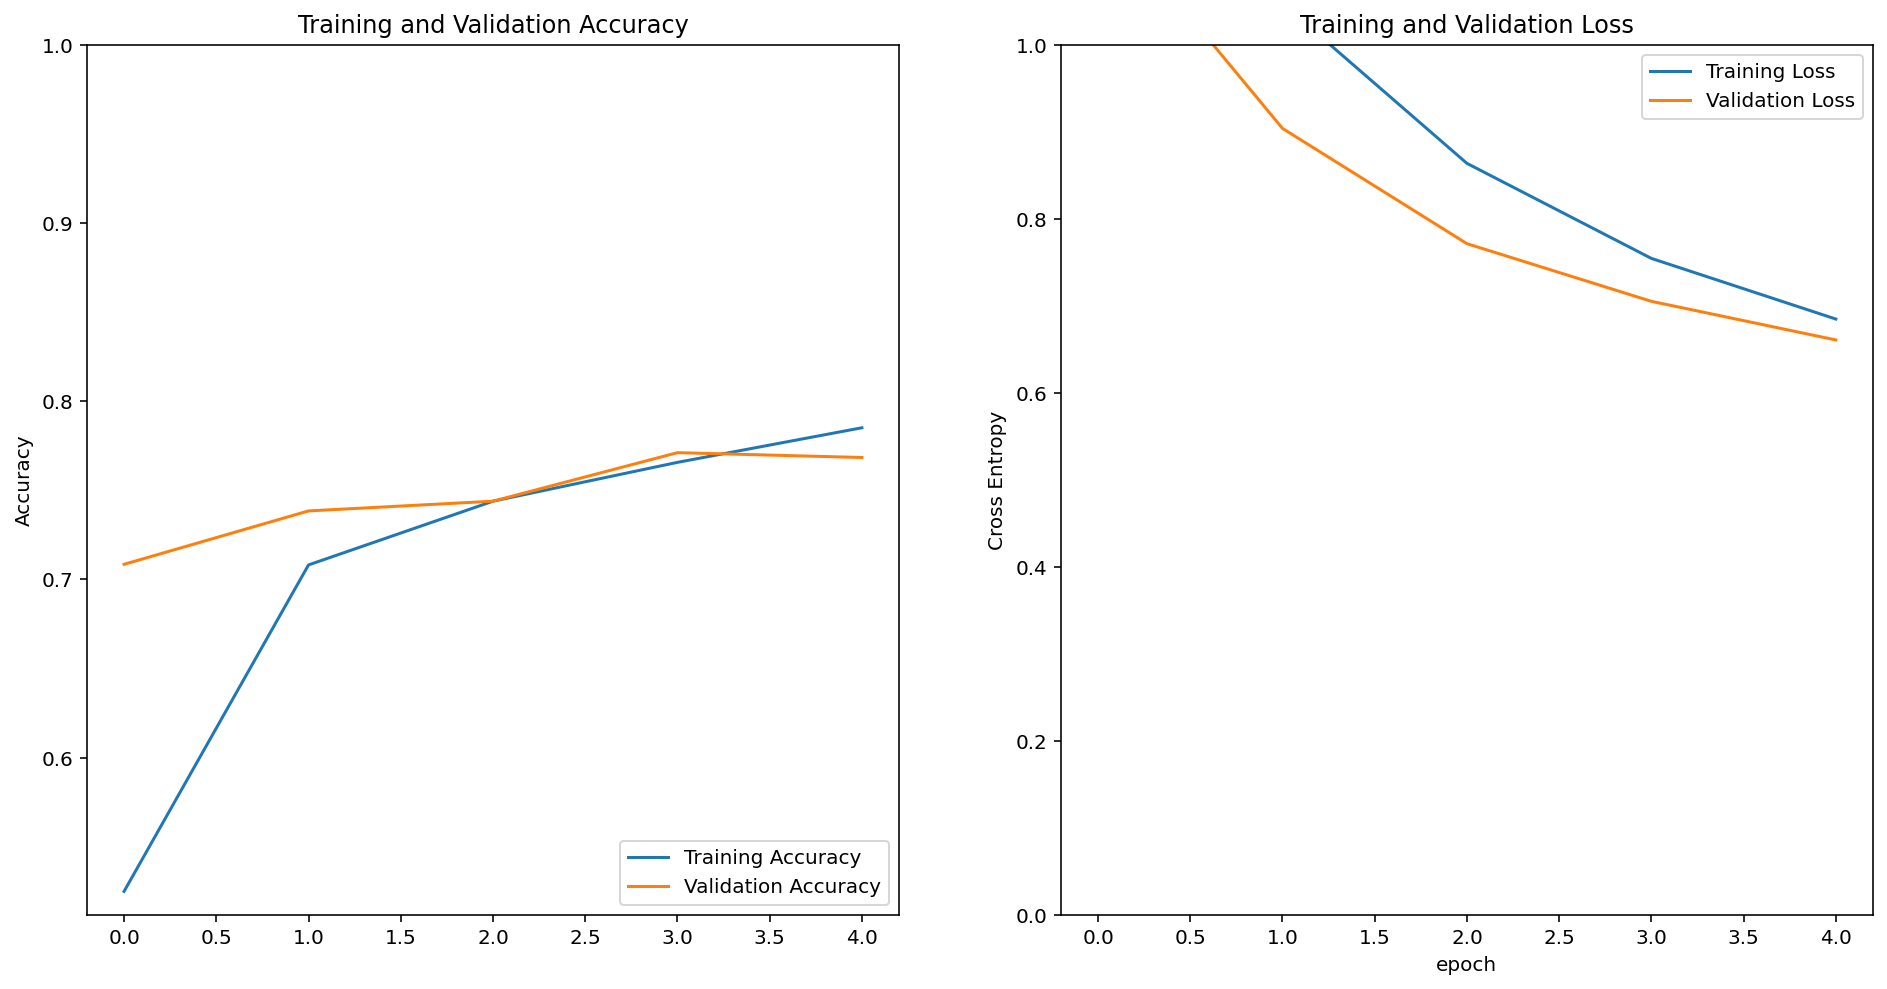

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = VGG16_model.predict(image_batch)
    pass

predictions

array([[5.55186197e-02, 9.36514363e-02, 5.55696905e-01, 1.42816484e-01,
        1.52316570e-01],
       [9.86697733e-01, 6.25111116e-03, 5.34297433e-04, 4.09547007e-03,
        2.42144382e-03],
       [7.02474535e-01, 9.90449563e-02, 4.10334133e-02, 1.07484013e-01,
        4.99630757e-02],
       [1.73472371e-02, 4.64396738e-02, 4.02287632e-01, 3.07708960e-02,
        5.03154516e-01],
       [5.79258800e-01, 2.55883574e-01, 4.54293378e-02, 4.08258997e-02,
        7.86023960e-02],
       [8.12825680e-01, 8.09171423e-02, 2.78194658e-02, 6.75930157e-02,
        1.08446795e-02],
       [3.88731174e-02, 4.07912172e-02, 4.69643235e-01, 2.97653407e-01,
        1.53039038e-01],
       [3.55595320e-01, 3.16687346e-01, 1.12371184e-02, 2.72126764e-01,
        4.43535447e-02],
       [4.98124994e-02, 1.70152057e-02, 4.93948683e-02, 7.32783616e-01,
        1.50993884e-01],
       [9.92692411e-01, 3.58319120e-03, 1.40855016e-04, 3.27747059e-03,
        3.06128466e-04],
       [9.33232844e-01, 3.1763

In [38]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 4, 0, 0, 2, 0, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       4, 0, 1, 4, 2, 4, 4, 3, 0, 4])

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'green'})
    plt.axis('off')

In [41]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 

78.125
